# Neural Network Model of Memory Retrieval

Replication of Recanatesi et al., 2015 https://www.frontiersin.org/articles/10.3389/fncom.2015.00149/full

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from model import RecallModel
from helpers import *

## 1. Initiation

1. Generate memories
2. Generate neuronal populations (dimensionality reduction)
3. Generate prototype connectivity matrix $J_{ij}$ without $\phi$
4. Build a hashmap of corresponding populations per memory

In [2]:
model = RecallModel()
model.init()

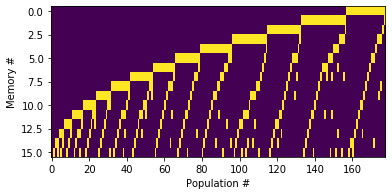

In [3]:
# Plot the populations
plt.figure()
plt.imshow(model.pops.T, aspect=5)
plt.xlabel('Population #')
plt.ylabel('Memory #')
plt.show()

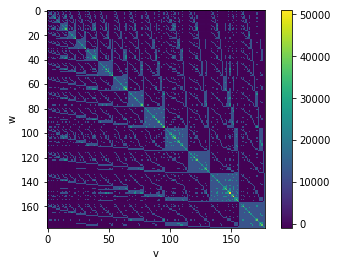

In [4]:
# Plot the prototype connectivity matrix
plt.figure()
plt.imshow(model.proto_conn_mat, aspect=1)
plt.xlabel('v')
plt.ylabel('w')
plt.colorbar()
plt.show()

## 2. Simulation of One Epoch

1. Generate a sequence of inhibition $\phi$
2. Start Simulation

In [ ]:
INIT_MEM = 7
avg_firing_rates = model.run(init_mem = INIT_MEM)

13574it [00:08, 1547.85it/s]

In [ ]:
# Plot epoch
plt.figure()
plt.imshow(avg_firing_rates, aspect='auto', extent = [0, 16, 16, 0])
plt.xlabel('Cycles')
plt.ylabel('Memory #')
plt.colorbar()
plt.show()

In [ ]:
# Plot average firing rates of memories
plt.figure()
plt.plot(avg_firing_rates.T)
plt.xlabel('Cycles')
plt.ylabel('Memory #')
plt.show()

In [ ]:
print("Memories recalled are: " + str(mem_activities_to_single_mem_transitions(avg_firing_rates)))